In [0]:
cd ..


/


In [0]:
mkdir root/.kaggle

In [0]:
api_token = {"username":"amarlatchireddy","key":"d1927120ebdf3ead33a9cda469c43340"}
import json
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
mkdir amazon_logistic_regression

In [0]:
cd amazon_logistic_regression

/amazon_logistic_regression


In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 95% 238M/251M [00:01<00:00, 167MB/s]
100% 251M/251M [00:01<00:00, 162MB/s]


In [0]:
!unzip amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
con=sqlite3.connect('database.sqlite')
#take the data which is not equal to three
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews where Score!=3 LIMIT 100000""",con)
#let us take the score which is less than 3 as negative and greater than 3 as positive
def partition(x):
    if x > 3 :
        return 1
    return 0
#change the value of scores
actual_score=filtered_data['Score']
positive_negative=actual_score.map(partition)
filtered_data['Score']=positive_negative
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
#Deleting duplicate entries
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","Time","ProfileName","Text"},keep='first',inplace=False)

In [0]:
final.shape

(87775, 10)

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
final['Score'].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [0]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."


In [0]:
final_data=pd.Series(['final'])
final_data.sample(frac=1)ledu


0    final
dtype: object

In [0]:
final_data.head()

0    final
dtype: object

In [0]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."


## Preprocessing
## Data cleaning

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
#setting stop words
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:

from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2525.22it/s]


In [0]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV



In [0]:
x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews,final["Score"],test_size=0.3)

In [0]:
#BOW
count_vec=CountVectorizer()
count_vec.fit(preprocessed_reviews)
print("some of fetures names are :",count_vec.get_feature_names()[0:1000])
final_counts=count_vec.transform(preprocessed_reviews)
print("type:",type(final_counts))
print("unique:",final_counts.get_shape()[1])

some of fetures names are : ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaah', 'aaaand', 'aaah', 'aaahs', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhhs', 'aahing', 'aahs', 'aamazon', 'aap', 'aarthur', 'aarti', 'aasanfood', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abates', 'abb', 'abbaye', 'abberline', 'abbey', 'abbott', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abcessed', 'abd', 'abdomen', 'abdominal', 'abe', 'abeneficial', 'aberration', 'abetter', 'abhor', 'abhors', 'abid', 'abide', 'abiding', 'abig', 'abilities', 'ability', 'abilling', 'abit', 'abita', 'ablaze', 'able', 'ablity', 'ablution', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abnoxious', 'aboard', 'abode', 'abolitionists', 'abolutely', 'abolutley', 'abomination', 'abominations', 'abondant', 'aboout', 'abor', 'aborio', 'aboslutely', 'abosolutly', 'abosoutely', 'abosrb', 'abosutely', 'abot', 'abottle

In [0]:
xl_train=count_vec.fit_transform(x_train)
xl_test=count_vec.transform(x_test)


In [0]:
parameters = {'penalty':['l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters,cv=10,n_jobs=-1)

In [0]:
search_hyp.fit(xl_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print(search_hyp.best_score_)
print(search_hyp.best_params_)
print(search_hyp.best_estimator_)

0.9007177617551798
{'C': 1, 'penalty': 'l2'}
LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(xl_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

0 th percentile :  0.0
10 th percentile :  0.0
20 th percentile :  0.0
30 th percentile :  0.0
40 th percentile :  0.0
50 th percentile :  0.0
60 th percentile :  0.0
70 th percentile :  0.0
80 th percentile :  0.0
90 th percentile :  0.024827640054832675
100 th percentile :  101253643.24096498


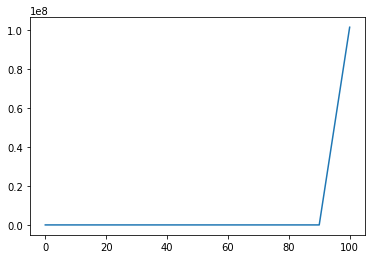

In [0]:
previous_weights=classifier.coef_#weight vector
noise=xl_train.astype('float')
noise.data+=0.001
classifier2 = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier2.fit(noise,y_train)
new_weights=classifier2.coef_#new weight vector
#percange change between new and old weights
previous_weights=previous_weights+10**-6
new_weights=new_weights+10**-6
change=abs((previous_weights-new_weights)/previous_weights)*100
t = range(0,101,10)
for i in t:
    print(i, "th percentile : ",np.percentile(change,i))

plt.plot(t,np.percentile(change,t) )

In [0]:
for j in range(90,101,1):
    print(j,"th percentile :",np.percentile(change,j))

90 th percentile : 0.024827640054832675
91 th percentile : 0.03907377429646404
92 th percentile : 0.051627085488394356
93 th percentile : 0.06534539968985491
94 th percentile : 0.07888635561579825
95 th percentile : 0.09794890001417539
96 th percentile : 0.13114494718613734
97 th percentile : 0.19263341436096865
98 th percentile : 0.3581007010758035
99 th percentile : 0.9516965702145588
100 th percentile : 101253643.24096498


In [0]:
l=np.linspace(99,99.9,10)
for k in l:
    print(k,"th percentile:",np.percentile(change,k))

99.0 th percentile: 0.9516965702145588
99.1 th percentile: 1.0938353787256019
99.2 th percentile: 1.3990771989534143
99.3 th percentile: 1.8218452055295404
99.4 th percentile: 2.48387386548462
99.5 th percentile: 3.3994614940306045
99.60000000000001 th percentile: 6.481900943702876
99.7 th percentile: 21.317404531078395
99.80000000000001 th percentile: 67.12721192971918
99.9 th percentile: 120.33654466589691


In [0]:
diff = abs((previous_weights-new_weights)/previous_weights)*100
q = diff[np.where(diff > 2.5)].size
print("Percentage of features which did not change by more than 2.5% is :",(previous_weights.size - q)/previous_weights.size*100)

Percentage of features which did not change by more than 2.5% is : 99.40209267563527


In [0]:
count_vect=CountVectorizer()
p=count_vect.fit_transform(x_train)
p = pd.DataFrame(diff.T,columns=['%change'])
p['feature'] = count_vect.get_feature_names()
q = p.sort_values(by = '%change',kind = 'quicksort',ascending= False)
p1 = q.loc[q['%change']>2.5]
print("The features which got changed by more than 2.5% are : \n",np.array(p1['feature']))

The features which got changed by more than 2.5% are : 
 ['bitterish' 'lighted' 'grantedand' 'wrongi' 'labor' 'domain' 'survive'
 'carpet' 'americano' 'online' 'prostate' 'fur' 'steaks' 'stations'
 'fragmentatized' 'cooking' 'fgound' 'amused' 'spicybut' 'amarillos'
 'inhibits' 'wle' 'havebut' 'awfulonly' 'hocker' 'splotchy' 'nutritious'
 'moonpie' 'respone' 'anywayz' 'honestlyy' 'thesa' 'purchasest'
 'recommendig' 'lsfjewldf' 'yadayadayada' 'ingredientsdislike'
 'objectively' 'knowthis' 'iove' 'wintergreens' 'directionsfrom'
 'earthquakes' 'chao' 'coffins' 'asfar' 'popovers' 'kookoo' 'buchanan'
 'shouldnt' 'eye' 'mrcoffe' 'guavaturned' 'flavorite' 'arrogance'
 'homesick' 'featherweight' 'dumpling' 'theacception' 'usthe' 'misprintor'
 'trees' 'thus' 'lskejfewl' 'hei' 'elegible' 'caloriesdeceptive' 'isbn'
 'utter' 'carbonate' 'saturated' 'energys' 'nocks' 'thunder' 'betters'
 'shutting' 'dissaponited' 'ovenand' 'opinon' 'disinfectant' 'awalnut'
 'dioxode' 'timeshares' 'combimation' 'nurt

There is no multi-collinearity

## Sparsity check


In [0]:
classifierSPAR = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifierSPAR.fit(xl_train, y_train)
weight=classifierSPAR.coef_
a=np.count_nonzero(weight)
b=weight.size
print("sparsity:",((b-a)/b*100))

sparsity: 88.19566300556747
